In [14]:
import os
import math

import cv2
import numpy as np
import paddle

from paddleseg import utils
from paddleseg.core import infer
from paddleseg.utils import logger, progbar, visualize, get_image_list
from paddleseg.cvlibs import manager
from paddleseg.transforms import Compose

In [15]:
model = manager.MODELS.components_dict['SegFormer_B2'](num_classes=20)
model_path = './best_model/model.pdparams'

In [16]:
transforms = Compose([manager.TRANSFORMS['Normalize']()])
transforms

In [17]:
image_list, image_dir = get_image_list('../datasets/test/image/')
image_list, image_dir

(['../datasets/test/image/08909_00.jpg', '../datasets/test/image/m_00002.jpg'],
 '../datasets/test/image/')

In [18]:
# 读取 CIHP_PGN 使用的 color map
import pickle
with open('../colormap.pkl', 'rb') as file:
    color_map = pickle.load(file)

print(f'Type: {type(color_map)}, Length: {len(color_map)}')

Type: <class 'list'>, Length: 768


In [19]:
# Paddleseg 提供的高层 API
from paddleseg.core import predict
predict(model, 
        model_path=model_path, 
        transforms=transforms, 
        image_list=image_list, 
        image_dir=image_dir, 
        save_dir='output',
        custom_color=color_map)

2022-03-17 15:05:05 [INFO]	Loading pretrained model from ./best_model/model.pdparams
2022-03-17 15:05:05 [INFO]	There are 347/347 variables loaded into SegFormer.
2022-03-17 15:05:05 [INFO]	Start to predict...


2/2 [==============================] - 0s 152ms/step


## 自定义 Inference

In [20]:
from pathlib import Path
from PIL import Image

# 仅做 Inference
utils.utils.load_entire_model(model, model_path)
model.eval()

progbar_pred = progbar.Progbar(target=len(image_list), verbose=1)

# 指定输出的分割图路径
out_img_dir = Path('./output/res')

logger.info("start to predict...")
with paddle.no_grad():
    for i, im_path in enumerate(image_list):
        print(i, im_path)
        im = cv2.imread(im_path)
        ori_shape = im.shape[:2]
        im, _ = transforms(im)
        im = im[np.newaxis, ...]
        im = paddle.to_tensor(im)
        
        pred, _ = infer.inference(model, 
                                  im, 
                                  ori_shape=ori_shape, 
                                  transforms=transforms.transforms, 
                                  is_slide=False, 
                                  stride=False, 
                                  crop_size=None)
        pred = paddle.squeeze(pred)
        pred = pred.numpy().astype('uint8')
        
        # 输出添加调色板信息的分割图
        img_name = Path(im_path).stem
        pred_mask = Image.fromarray(pred, mode='P')
        pred_mask.putpalette(color_map)
        out_img_dir.mkdir(parents=True, exist_ok=True)
        pred_mask.save(f'{out_img_dir.joinpath(img_name)}.png')

2022-03-17 15:05:07 [INFO]	Loading pretrained model from ./best_model/model.pdparams
2022-03-17 15:05:07 [INFO]	There are 347/347 variables loaded into SegFormer.
2022-03-17 15:05:07 [INFO]	start to predict...
0 ../datasets/test/image/08909_00.jpg
1 ../datasets/test/image/m_00002.jpg


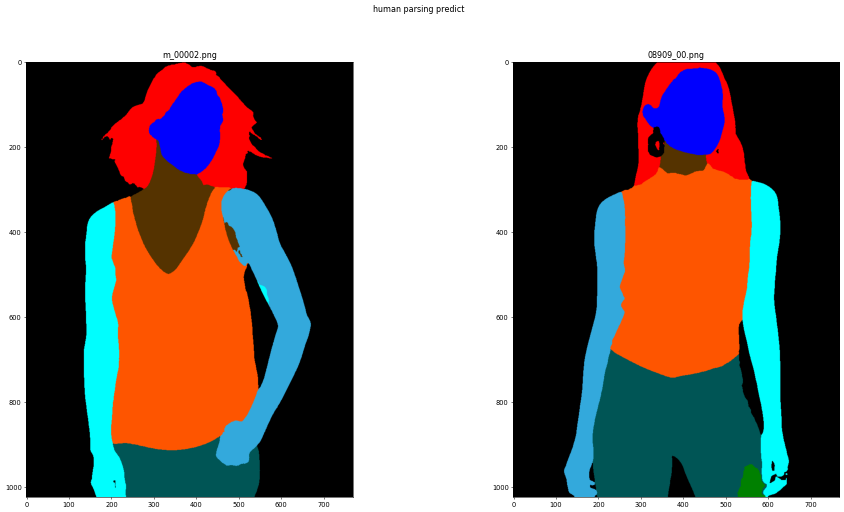

In [24]:
import matplotlib.pyplot as plt
import cv2
from pathlib import Path

def show_imgs(imgs, horizon=True, h=24, w=12):
    plt.figure(figsize=(h, w), dpi=48)
    plt.suptitle("human parsing predict")
    for i, img in enumerate(imgs):
        if horizon:
            sub_plt = plt.subplot(1, len(imgs), i+1)
        else:
            sub_plt = plt.subplot(len(imgs), 1, i+1)
        _, img_name = img.rsplit('/', 1)
        img = cv2.imread(img)
        sub_plt.imshow(img[:,:,::-1])
        sub_plt.set_title(img_name)

img_root_dir = Path('./output/res/')
imgs = [ str(i) for i in img_root_dir.glob('./*.png')]
imgs

show_imgs(imgs)

In [25]:
!cp -r ./output/res/*.png ../datasets/test/image-parse/